# NLP Analysis of Disasters on Social Media


## 1 Executive Summary

The abundance of social media data has revolutionazed the way we approach big crisis such as earthquake and floods. On the personal level, people who are at the frontier of those events would take pictures or seek helps on social media. On the public level, government and international organization have been trying to utilize those social media data to make actionable decisions. For example, by analyzing tweets with searches of "earthquake", the government will be able to gain awareness of the emergencies and the urgent needs of people at different locations, and allocate resources accordingly. 

However, there still remains two main challenges when it comes to nalyzing those data: 

* Social media data are messy and contains underlying semantics that are hard to be understood. For instance, a tweet mentioned a disaster could be an emergency or could simply be a joke. 
* Supervised learning models need labeled data and it takes time to be trained. However, in the early hours of a disaster, such kind of labeled data are normally not available. 


## 2 Background




### 2.1 Objective

This project aims to anwer two questions:

- Given a tweet, can we accurately classify it into a real disaster event from the noise?  
- Is it possible to rapidly classify disaster events in a timely manner? 



### 2.2 Dataset Description

The dataset is from [CrisisNLP](http://crisisnlp.qcri.org/lrec2016/lrec2016.html). It contains crisis-related Twitter data about 9 disaster events such as floods, earthquake, typhoon. Each tweet is labeled into 1-8 informative classes by paid workers, with one class of "not related or irrelevant" class. I concatenated and cleaned the raw dataset in *NLP_data_preparation.ipynb*. The dataset at hand now (after concatenation) has 19,112 rows with 4 columns. 

The four disaster events of concerns are:
* Nepal Earthquake (2015)
* Cyclone PAM in Vanuau (2015)
* California Earthquake (2014)
* Typhoon Hagupit in Phillippines (2014)

There are no missing values in this dataset.

In [1]:
# load libaries

import pandas as pd
import numpy as np
import nltk
import re
import codecs

In [14]:
# inspect the raw data

raw = pd.read_csv("data/events.csv")
print(raw.shape)
raw.head()

(19112, 4)


tweet_id                                         tweet_text  \
0  '591902695562170368'  RT @PTI_News: Govt asks media houses to exerci...   
1  '591902695822331904'  #money #news #top #b Magnitude-7.9 quake hits ...   
2  '591902695943843840'  RT @ABCNews24: #NepalEarthquake update: The In...   
3  '591902696371724288'  RT @cnni: CNN obtains powerful images of baby ...   
4  '591902696375877632'  My thoughts and prayers to everyone in Nepal.....   

                                 label          event  
0             other_useful_information  2015_nepal_eq  
1  infrastructure_and_utilities_damage  2015_nepal_eq  
2               injured_or_dead_people  2015_nepal_eq  
3      missing_trapped_or_found_people  2015_nepal_eq  
4       sympathy_and_emotional_support  2015_nepal_eq

In [16]:
# quickly look into the lable values

class_label = raw.label.value_counts().rename('num_class').reset_index()
class_label['Percent'] = (class_label.num_class/raw.shape[0])*100
pd.DataFrame(class_label)

index  num_class    Percent
0                           other_useful_information       5729  29.975931
1  donation_needs_or_offers_or_volunteering_services       2610  13.656342
2                             injured_or_dead_people       2510  13.133110
3                          not_related_or_irrelevant       2345  12.269778
4                     sympathy_and_emotional_support       1969  10.302428
5                infrastructure_and_utilities_damage       1851   9.685015
6                                 caution_and_advice       1063   5.561951
7                   displaced_people_and_evacuations        633   3.312055
8                    missing_trapped_or_found_people        402   2.103391

label  % of Count
other_useful_information                            5729   29.975931
donation_needs_or_offers_or_volunteering_services   2610   13.656342
injured_or_dead_people                              2510   13.133110
not_related_or_irrelevant                           2345   12.269778
sympathy_and_emotional_support                      1969   10.302428
infrastructure_and_utilities_damage                 1851    9.685015
caution_and_advice                                  1063    5.561951
displaced_people_and_evacuations                     633    3.312055
missing_trapped_or_found_people                      402    2.103391

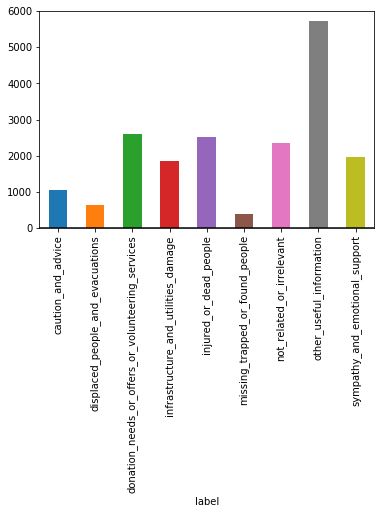

In [17]:
# define a function inspect the distribution of the data

%matplotlib inline
import matplotlib.pyplot as plt

def count_table(df, c):
        count = df[c].value_counts()
        count_percent = 100 * count / len(df)
        count_table = pd.concat([count, count_percent], axis=1)
        
        count_table.columns = [c, '% of Count']
        count_table.round(2)

        gb = df.groupby(df[c])
        targetEDA=gb[c].aggregate(len)
        
        plt.figure()
        targetEDA.plot(kind='bar', grid=False)
        plt.axhline(0, color='k')
        
        return count_table

count_table(raw, 'label')

As we can see from the plot, 'Not related or irrelevant' is the most frequent class. I am going to encode the labels into 1 and 0 later for binary classification purpose. 

event  % of Count
2015_nepal_eq                 3018   15.791126
2013_pakistan_eq              2013   10.532650
2014_pakistan_floods          2013   10.532650
2015_Cyclone_Pam              2013   10.532650
2014_California_Earthquake    2013   10.532650
2014_Hurricane_Odile_Mexico   2013   10.532650
2014_Philippines_Typhoon      2013   10.532650
2014_Chile_Earthquake         2013   10.532650
2014_india_floods             2003   10.480326

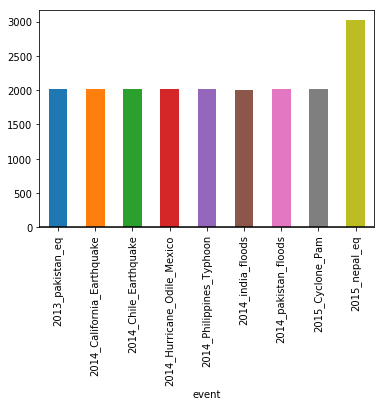

In [18]:
count_table(raw, 'event')

## 3 Data Preprocessing

The item columns contains the raw tweets posted by the users. It is easy to see there are lots of noise when it comes to tweets data. We need to clean and tokenize these tweets to abstract useful information.

There are several issues I need to consider later: 
- 140 charaters tweets normally doesn't provide much context information
- tweets can be ambiguous given people are using informal languages and slangs

Given those issues, I have in mind that I might need to use different processing/tokenizitoin methods to deal with tweets from the methods of dealing with traditional texts. 


### 3.1 Data Cleaning

The cleaning steps is as following: 

1. normalizing to utf-8 
2. lowercasing 
2. Digit -> DDD 
3. URLs -> httpAddress 
4. @username -> userID 
5. Remove special characters, keep ; . ! ? 
6. normalize elongation 

In [2]:
import re, os
import csv
import string 
import twokenize
from collections import defaultdict
import codecs
import unicodedata

In [22]:
# build a container to process the data 
# list works better here than dataframe 

columns = defaultdict(list) # each value in each column is appended to a list

with open("data/events.csv", newline='') as f:
    reader = csv.DictReader(f) # read rows into a dictionary format
    for row in reader: # read a row as {column1: value1, column2: value2,...}
        for (k,v) in row.items(): # go over each column name and value 
            columns[k.strip()].append(v) # append the value into the appropriate list based on column name k

# columns

In [38]:
# define a function to clean the item column 

def clean_text(lst):
    clean_tweet = []
    for tweet in lst:
        print ("[original]", tweet)

        # 1. normalizing utf8 formatting 
        tweet = tweet.encode("utf8").decode("utf8")
#         tweet = tweet.encode("ascii","ignore")
        tweet = tweet.strip(' \t\n\r')
    
        # 2. lowering case 
        tweet = re.sub(' +', ' ', tweet)
        tweet = tweet.lower()
        print ("[lowercase]", tweet)

        # 3. normalizing digits
        tweet_words = tweet.strip('\r').split(' ')
        for word in [word for word in tweet_words if word.isdigit()]:
            tweet = tweet.replace(word, "D" * len(word))
        print ("[digits]", tweet)
        
        # 4. normalizing urls
        tweet_words = tweet.strip('\r').split(' ')
        for word in [word for word in tweet_words if '/' in word or '.' in word and len(word) > 3]:
            tweet = tweet.replace(word, "urls")
        print ("[urls]", tweet)
        
        #5. username 
        tweet_words = tweet.strip('\r').split(' ')
        for word in [word for word in tweet_words if word[0] == '@' and len(word) > 1]:
            tweet = tweet.replace(word, "usrId")
        print ("[username]", tweet)
        
        # 6. special characters
        punc = '#@$%^&*()_+-={}[]:"|\'\~`<>/,'
        trans = str.maketrans(punc, ' '*len(punc))
        tweet = tweet.translate(trans)
        print ("[punctuation]", tweet)
        
        # 7. Normalizing +2 elongated char
        tweet = re.sub(r"(.)\1\1+",r'\1\1', tweet)
        print ("[elong]", tweet)
        
        # 8. fix \n char
        tweet = tweet.replace('\n', ' ')

        clean_tweet.append(tweet.strip())

    return clean_tweet



In [ ]:
clean = clean_text(columns['tweet_text']);

In [40]:
# write the clean text data

with open("data/events_clean.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["tweet_id","tweet_text","label", "event"])
    rows = zip(columns['tweet_id'], clean, columns['label'], columns['event'])
    for row in rows:
        writer.writerow(row)

In [4]:
data = pd.read_csv("data/events_clean.csv")
data.head()

tweet_id                                         tweet_text  \
0  '591902695562170368'  rt usrId govt asks media houses to exercise re...   
1  '591902695822331904'  money  news  top  b urls quake hits nepal  cau...   
2  '591902695943843840'  rt usrId  nepalearthquake update  the indian a...   
3  '591902696371724288'  rt usrId cnn obtains powerful images of baby r...   
4  '591902696375877632'   my thoughts and prayers to everyone in urls urls   

                                 label          event  
0             other_useful_information  2015_nepal_eq  
1  infrastructure_and_utilities_damage  2015_nepal_eq  
2               injured_or_dead_people  2015_nepal_eq  
3      missing_trapped_or_found_people  2015_nepal_eq  
4       sympathy_and_emotional_support  2015_nepal_eq

### 3.2 Data Preparation

After we have the clean twitter text, there are several things we need to do:

* encodding: "other_useful_information" and "not_related_or_irrelevant" as 0, others as 1
* split the data into train and test
* tokenization using [NLTK](https://www.nltk.org) or [tweetNLP](http://www.ark.cs.cmu.edu/TweetNLP)


In [5]:
# tokenize the data with nltk

from nltk.tokenize import RegexpTokenizer

# w, \W: ANY ONE word/non-word character. 
# For ASCII, word characters are [a-zA-Z0-9_]
tokenizer = RegexpTokenizer(r'\w+')

data["tokens"] = data["tweet_text"].apply(tokenizer.tokenize)
data.head()

tweet_id                                         tweet_text  \
0  '591902695562170368'  rt usrId govt asks media houses to exercise re...   
1  '591902695822331904'  money  news  top  b urls quake hits nepal  cau...   
2  '591902695943843840'  rt usrId  nepalearthquake update  the indian a...   
3  '591902696371724288'  rt usrId cnn obtains powerful images of baby r...   
4  '591902696375877632'   my thoughts and prayers to everyone in urls urls   

                                 label          event  \
0             other_useful_information  2015_nepal_eq   
1  infrastructure_and_utilities_damage  2015_nepal_eq   
2               injured_or_dead_people  2015_nepal_eq   
3      missing_trapped_or_found_people  2015_nepal_eq   
4       sympathy_and_emotional_support  2015_nepal_eq   

                                              tokens  
0  [rt, usrId, govt, asks, media, houses, to, exe...  
1  [money, news, top, b, urls, quake, hits, nepal...  
2  [rt, usrId, nepalearthquake, update, the, indi...  
3  [rt, usrId, cnn, obtains, powerful, images, of...  
4  [my, thoughts, and, prayers, to, everyone, in,...

[tweetNLP](https://github.com/myleott/ark-twokenize-py) is a tokenizer developed for Twitter text. 


In [6]:
# look into the tokens 
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in data["tokens"] for word in tokens]
vocab = sorted(list(set(all_words))) # get rid of duplicates words by set
sentence_lengths = [len(tokens) for tokens in data["tokens"]]

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(vocab)))
print("Max sentence length is %s" % max(sentence_lengths))


313289 words total, with a vocabulary size of 19542
Max sentence length is 47


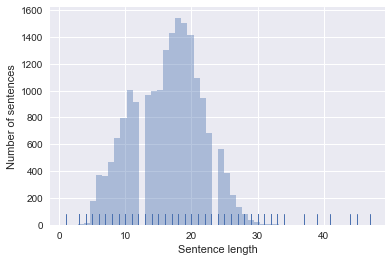

In [46]:
# a simple plot to look into the sentences 

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
sns.distplot(sentence_lengths, kde=False, rug=True)

From here, we know that the length of the tweets are centered around 15 - 20 words. 

## 4 Model Training

### Enbeddings

Next step, we need to encode texts in order to feed them into algorithms. 

Embedding is a representation of the document. It is known as a process of "learning a distributed representation for words". There are different practices, and I'll start from the simplest and the traditional one of BoW, and try other more advanced methods out later.


### 4.1 Bag of Words (BoW)

Bag of words is a model that simply count the number of each word in each sentence, and represent a sentence with the word count. With this model, we will get a very sparse matrix that each row indicate a sentence and columns indicate the whole vocabulary of our dataset. 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def emb(data):
    count_vectorizer = CountVectorizer()
    embedding = count_vectorizer.fit_transform(data)
    return embedding, count_vectorizer


In [8]:
# encode the class lable into 1 and 0 
# Not related or irrelevant = 0 

data['label_binary'] = [0 if x == 'not_related_or_irrelevant' else 1 for x in data.label]
data.head()

tweet_id                                         tweet_text  \
0  '591902695562170368'  rt usrId govt asks media houses to exercise re...   
1  '591902695822331904'  money  news  top  b urls quake hits nepal  cau...   
2  '591902695943843840'  rt usrId  nepalearthquake update  the indian a...   
3  '591902696371724288'  rt usrId cnn obtains powerful images of baby r...   
4  '591902696375877632'   my thoughts and prayers to everyone in urls urls   

                                 label          event  \
0             other_useful_information  2015_nepal_eq   
1  infrastructure_and_utilities_damage  2015_nepal_eq   
2               injured_or_dead_people  2015_nepal_eq   
3      missing_trapped_or_found_people  2015_nepal_eq   
4       sympathy_and_emotional_support  2015_nepal_eq   

                                              tokens  label_binary  
0  [rt, usrId, govt, asks, media, houses, to, exe...             1  
1  [money, news, top, b, urls, quake, hits, nepal...             1  
2  [rt, usrId, nepalearthquake, update, the, indi...             1  
3  [rt, usrId, cnn, obtains, powerful, images, of...             1  
4  [my, thoughts, and, prayers, to, everyone, in,...             1

label_binary  % of Count
1         16767   87.730222
0          2345   12.269778

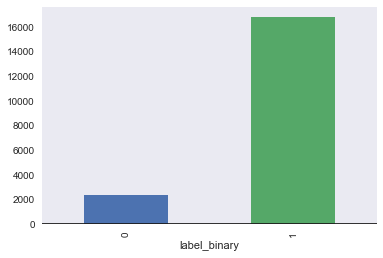

In [49]:
count_table(data, 'label_binary')

As we already seen earlier, this dataset is highly embalanced. I might need to deal with this later.

In [23]:
# seperate train and test

x = data['tweet_text'].tolist()
y = data['label_binary'].tolist()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=30)

print("length of X_train: %d, X_text: %d, y_train: %d, y_test: %d" % (len(X_train), len(X_test), len(y_train), len(y_test)))


length of X_train: 13378, X_text: 5734, y_train: 13378, y_test: 5734


In [53]:
# apply BoW

X_train_counts, count_vectorizer = emb(X_train)
X_test_counts = count_vectorizer.transform(X_test)

We'd like to visualy inspect this dataset by reducing the dimensionality. Here we apply latent semantic analysis [(LSA)](http://mccormickml.com/2016/03/25/lsa-for-text-classification-tutorial/) which perform linear dimensionality reduction on the text data. 

In [54]:
from sklearn.decomposition import PCA, TruncatedSVD

# reduce the dimensionality 
svd = TruncatedSVD(n_components=2)
svd.fit(X_train_counts)
lsa_bow = svd.transform(X_train_counts)
               
lsa_bow

array([[ 2.50628978, -0.13843315],
       [ 1.74614533, -0.97972996],
       [ 2.62695293,  0.24880873],
       ...,
       [ 2.23457028,  0.59697207],
       [ 1.00646428, -0.46785144],
       [ 2.56440791,  0.24251635]])

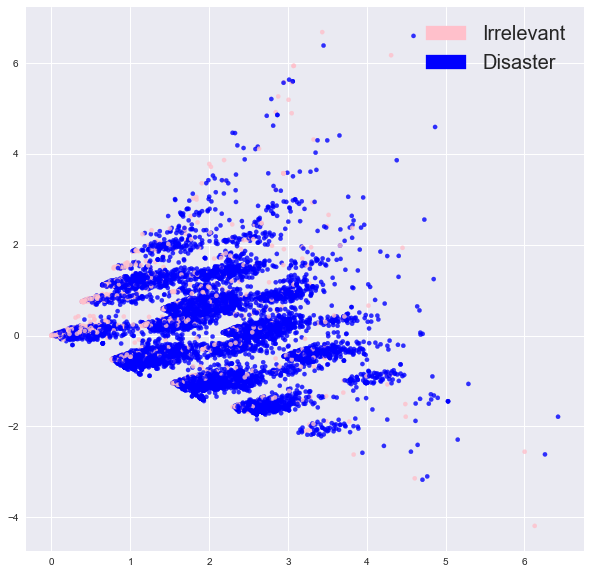

In [56]:
# visualize the word vectors

import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches

def plot_LSA(y_train, lsa_scores):
        color_mapper = {label:idx for idx, label in enumerate(set(y_train))}
        color_column = [color_mapper[label] for label in y_train]
        colors = ['pink','blue']

        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=18, alpha=.8, c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='pink', label='Irrelevant')
        green_patch = mpatches.Patch(color='blue', label='Disaster')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 20})

fig = plt.figure(figsize=(10, 10))      
plot_LSA(y_train, lsa_bow)
plt.show()

The enbeddings doesn't look seperable. 

I'd like to take a quick look into how well bag of words perform for this dataset by fitting a simple logistic regression on it. 

In [57]:
# try it out on logistic regression 

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_test_counts)


In [30]:
from sklearn import metrics

def metrics_df(y_test, y_predicted):
    
    test_accuracy = metrics.accuracy_score(y_test, y_predicted)
    test_recall = metrics.recall_score(y_test, y_predicted)
    test_precision = metrics.precision_score(y_test, y_predicted)
    test_f1 = metrics.f1_score(y_test, y_predicted)
    
#     train_accuracy_score_list = metrics.accuracy_score(train_Y,train_predictions)
#     train_recall_score_list = []
#     train_precision_score_list = []
#     train_f1_score_list = []
    
    cm = metrics.confusion_matrix(y_test,  y_predicted)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    class_0_accuracy = cm.diagonal()[0]
    class_1_accuracy = cm.diagonal()[1]
    
    results_df = pd.DataFrame(index=['accuracy','recall','precision','f1'])
    results_df['test'] = [test_accuracy, test_recall,
                           test_precision, test_f1]
    results_df['class_0_test'] = [class_0_accuracy,'-','-','-']
    results_df['class_1_test'] = [class_1_accuracy,'-','-','-']
    
    return results_df
    

In [59]:
metrics = metrics_df(y_test, y_predicted_counts)
metrics

test class_0_test class_1_test
accuracy   0.908790     0.659794     0.942235
recall     0.942235            -            -
precision  0.953744            -            -
f1         0.947955            -            -

As we can see, the result is not balanced. I'd like to look furthur into the confusion matrix. 

In [31]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=30)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

    return plt

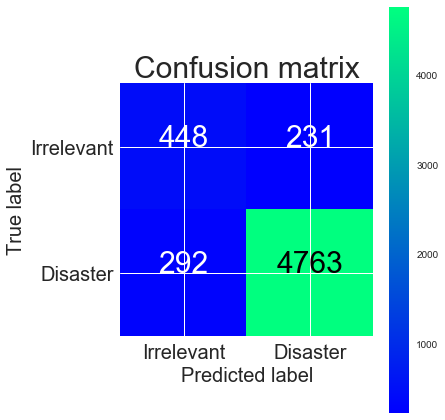

In [61]:
cm = confusion_matrix(y_test, y_predicted_counts)

fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()

In [62]:
cm_df = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
cm_df

0         1
0  0.659794  0.340206
1  0.057765  0.942235

From the confusion matrix, we can the classifier is doing well in predicting true disaster (94% true positive). 

It's easy to see that about 34% percent of irrelevant events are misclassified into disasters (false positive), and about 5% disasters are misclassified into irrelevant events (false negative). 

Different events here have significant different costs. For example, in the case of an earthquake, misclassifying disaster into irrelevant event could potentially lead to the delay for the government to take actions. I'd really like to see if I could furthur reduce the false negative and false positive. 

### Feature Importance

In [63]:
def get_most_important_features(vectorizer, model, n):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)
importance

{0: {'bottom': [(-3.5215146310418213, 'came'),
   (-3.542104893489556, 'typhoonhagupitruby'),
   (-3.5461072623797985, 'holy'),
   (-3.588965712385986, 'violence'),
   (-3.9330234827428785, 'newsinsight'),
   (-4.057608265093294, 'applause'),
   (-4.07390855247977, 'xfactornz'),
   (-4.078069475736963, 'wines'),
   (-4.224509986073966, 'pundits'),
   (-4.641712543737067, 'symbls')],
  'tops': [(2.8581353650625636, 'earthquakenepal'),
   (2.899712085671524, 'safe'),
   (2.9383732273876637, 'idea'),
   (3.0522941580823346, 'actforchile'),
   (3.1072045221991433, 'prayforgaza'),
   (3.17300680794238, 'floods'),
   (3.198600192826966, 'affect'),
   (3.313096270810301, 'prayers'),
   (3.4083424319309237, 'woken'),
   (3.5589819017282047, 'magnitude')]}}

In [64]:
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]

bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

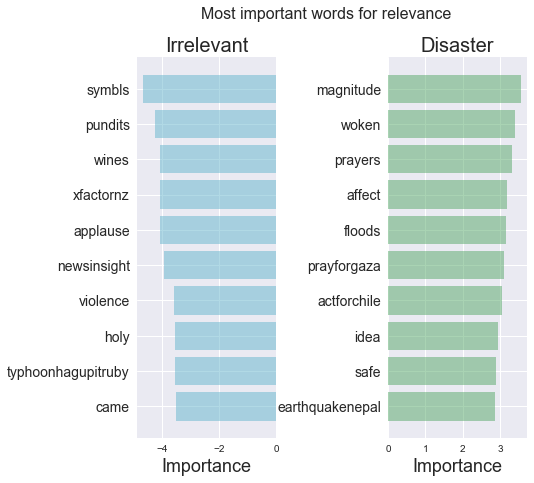

In [65]:
# plot out the importance 

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(7, 7))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5, color = 'c')
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=18)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5, color = 'g')
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=18)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()


plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

### 4.2 TF-IDF

TFIDF (Term Frequency, Inverse Document Frequency) is a commonly used practice for building word vector based their frequency. Each of the word will be normalized by its frequency in the whole corpus, more frequent words will have less weights since they are being considered addding noise. 

In [66]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [67]:
from sklearn.decomposition import PCA, TruncatedSVD

# reduce the dimensionality 
svd = TruncatedSVD(n_components=2)
svd.fit(X_train_tfidf)
lsa_tfidf = svd.transform(X_train_tfidf)
               
lsa_tfidf

array([[ 0.26180895, -0.00654964],
       [ 0.11814258, -0.01240667],
       [ 0.19638877, -0.03783945],
       ...,
       [ 0.24941679, -0.08558005],
       [ 0.10987018, -0.00948668],
       [ 0.13127314, -0.00737316]])

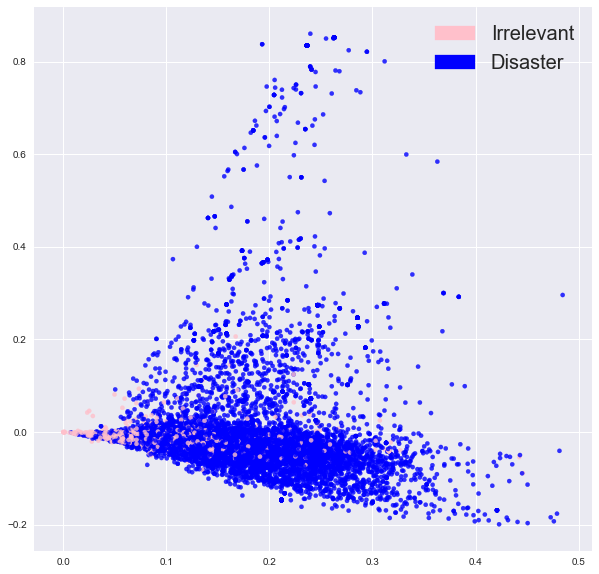

In [69]:
fig = plt.figure(figsize=(10, 10))         
plot_LSA(y_train, lsa_tfidf)
plt.show()

From this graph, we can see that the embedding of tfidf is still not very separable. 

In [70]:
# try it out on logistic regression 

from sklearn.linear_model import LogisticRegression

clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)


In [71]:
from sklearn import metrics

def metrics_df(y_test, y_predicted):
    
    test_accuracy = metrics.accuracy_score(y_test, y_predicted)
    test_recall = metrics.recall_score(y_test, y_predicted)
    test_precision = metrics.precision_score(y_test, y_predicted)
    test_f1 = metrics.f1_score(y_test, y_predicted)
    
#     train_accuracy_score_list = metrics.accuracy_score(train_Y,train_predictions)
#     train_recall_score_list = []
#     train_precision_score_list = []
#     train_f1_score_list = []
    
    cm = metrics.confusion_matrix(y_test,  y_predicted)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    class_0_accuracy = cm.diagonal()[0]
    class_1_accuracy = cm.diagonal()[1]
    
    results_df = pd.DataFrame(index=['accuracy','recall','precision','f1'])
    results_df['test'] = [test_accuracy, test_recall,
                           test_precision, test_f1]
    results_df['class_0_test'] = [class_0_accuracy,'-','-','-']
    results_df['class_1_test'] = [class_1_accuracy,'-','-','-']
    
    return results_df
    
metrics_df(y_test, y_predicted_tfidf)

test class_0_test class_1_test
accuracy   0.910882     0.643594     0.946785
recall     0.946785            -            -
precision  0.951870            -            -
f1         0.949321            -            -

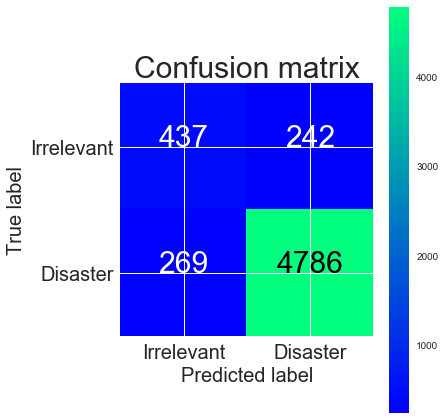

TFIDF confusion matrix
[[ 437  242]
 [ 269 4786]]
BoW confusion matrix
[[ 448  231]
 [ 292 4763]]


In [72]:
cm_tfidf = confusion_matrix(y_test, y_predicted_tfidf)

fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm_tfidf, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm_tfidf)

print("BoW confusion matrix")
print(cm)

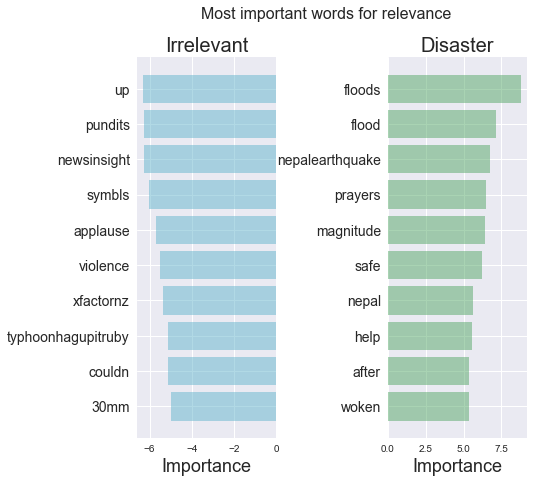

In [73]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

From confusion metric and feature importance, I don't see much improvement with TFIDF than BoW. In addition, the model could be a bit overfitting since there are more noise in this graph.

### 4.3 Word2vec

BoW and TFIDF are based on word frequency, and both don't take consideration of semantic meaning of the words. Another embedding model that captures semantic is [Word2vec](https://code.google.com/archive/p/word2vec/) released by Google. It is a pre-trained model that measure semantic by comparing the distance between words, and contains 300 dimensional vectors for 3 million words and phrases. 

Note: it is recommend to train with 64-bit Python.


In [74]:
# load the pre-trained model 
import gensim

# Load Google's pre-trained Word2Vec model.
word2vec_path = "word2vec/GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)  

In [20]:
# get sentence embeddings by averaging average word2vec score
import numpy as np

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
        
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged


In [21]:
def get_word2vec_embeddings(vectors, data, generate_missing=False):
    embeddings = data['tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [76]:
embeddings = get_word2vec_embeddings(word2vec, data)
embeddings = np.array(embeddings)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, y, test_size=0.3, random_state=40)

print("length of X_train: %d, X_text: %d, y_train: %d, y_test: %d" % (len(X_train_word2vec), len(X_test_word2vec), len(y_train_word2vec), len(y_test_word2vec)))

length of X_train: 13378, X_text: 5734, y_train: 13378, y_test: 5734


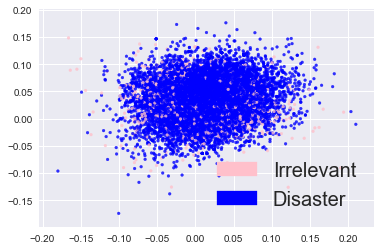

In [77]:
color_mapper = {label:idx for idx, label in enumerate(set(y))}
color_column = [color_mapper[label] for label in y]
colors = ['pink','blue']

plt.scatter(embeddings[:,0], embeddings[:,1], s=8, alpha=.8, c=y, cmap=matplotlib.colors.ListedColormap(colors))
red_patch = mpatches.Patch(color='pink', label='Irrelevant')
green_patch = mpatches.Patch(color='blue', label='Disaster')
plt.legend(handles=[red_patch, green_patch], prop={'size': 20})


fig = plt.figure(figsize=(15, 15))      
plt.show()

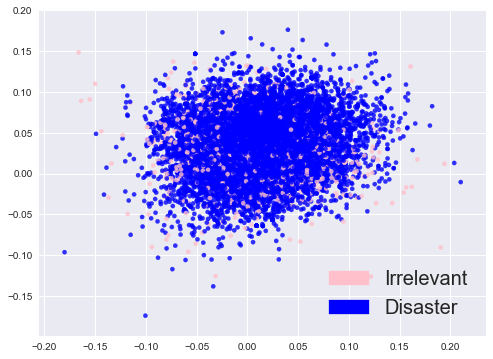

In [78]:
fig = plt.figure(figsize=(8, 6))         
plot_LSA(y, embeddings)
plt.show()

In [79]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [81]:
metrics_df(y_test_word2vec, y_predicted_word2vec)

test class_0_test class_1_test
accuracy   0.841821     0.821879     0.844652
recall     0.844652            -            -
precision  0.970925            -            -
f1         0.903398            -            -

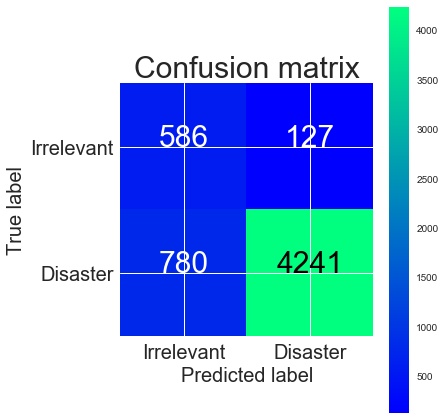

In [82]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)

fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm_w2v, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()

In [83]:
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm_tfidf)
print("BoW confusion matrix")
print(cm)

Word2Vec confusion matrix
[[ 586  127]
 [ 780 4241]]
TFIDF confusion matrix
[[ 437  242]
 [ 269 4786]]
BoW confusion matrix
[[ 448  231]
 [ 292 4763]]


### Use LIME to interpret word2vec

In [84]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(x, y, test_size=0.2, 
                                                                                random_state=40)
vector_store = word2vec

In [85]:
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [86]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["irrelevant","relevant", "unknown"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [87]:
visualize_one_exp(X_test_data, y_test_data, 65)

/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Index: 65
True class: relevant


In [88]:
visualize_one_exp(X_test_data, y_test_data, 60)

/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Index: 60
True class: relevant


Should I go back to cleaning and get rid of those noise?? 

In [89]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions



In [90]:
label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pa

/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pa

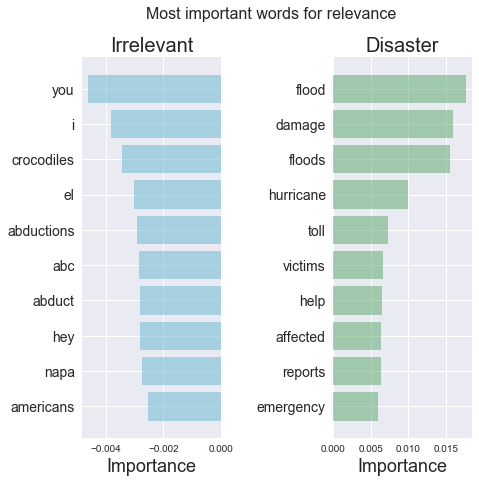

In [91]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Another word2vec model I'd like to try is the CrisisNLP Word2vec Model (V1.2). It's trained specially on crisis tweets and consists of a vocabulary with size 7976291 (~7 million) and 300 dimensional vector (large too). 

In [12]:
# load the pre-trained model 
import gensim

crisis_path = 'word2vec/crisisNLP_word2vec_model/crisisNLP_word_vector.bin'
crisis = gensim.models.KeyedVectors.load_word2vec_format(crisis_path, binary=True)
words=crisis.most_similar(positive=['shelter'], negative=[], topn=10)


/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [24]:
embeddings = get_word2vec_embeddings(crisis, data)
embeddings = np.array(embeddings)
X_train_word2vecc, X_test_word2vecc, y_train_word2vecc, y_test_word2vecc = train_test_split(embeddings, y, test_size=0.3, random_state=40)

print("length of X_train: %d, X_text: %d, y_train: %d, y_test: %d" % (len(X_train_word2vecc), len(X_test_word2vecc), len(y_train_word2vecc), len(y_test_word2vecc)))

length of X_train: 13378, X_text: 5734, y_train: 13378, y_test: 5734


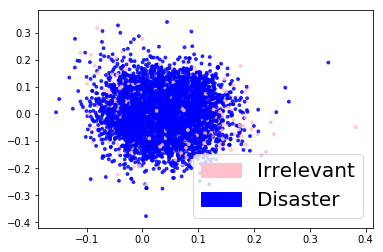

In [27]:
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches

color_mapper = {label:idx for idx, label in enumerate(set(y))}
color_column = [color_mapper[label] for label in y]
colors = ['pink','blue']

plt.scatter(embeddings[:,0], embeddings[:,1], s=8, alpha=.8, c=y, cmap=matplotlib.colors.ListedColormap(colors))
red_patch = mpatches.Patch(color='pink', label='Irrelevant')
green_patch = mpatches.Patch(color='blue', label='Disaster')
plt.legend(handles=[red_patch, green_patch], prop={'size': 20})


fig = plt.figure(figsize=(15, 15))      
plt.show()

In [28]:
# try it out on logistic regression 

from sklearn.linear_model import LogisticRegression

clf_crisis = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=40)
clf_crisis.fit(X_train_word2vecc, y_train_word2vecc)
y_predicted_w2cc = clf_crisis.predict(X_test_word2vecc)


In [32]:
metrics_df(y_test_word2vecc, y_predicted_w2cc)

test class_0_test class_1_test
accuracy   0.843565     0.834502     0.844852
recall     0.844852            -            -
precision  0.972936            -            -
f1         0.904381            -            -

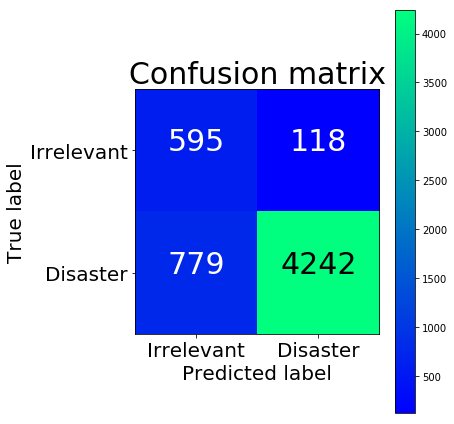

In [33]:
cm = confusion_matrix(y_test_word2vecc, y_predicted_w2cc)

fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.show()

## 5 Neural Nets Models

### 5.1 CNNs 

I'd like to try some deep learning models to capture sentence structures. Here, I used a simple CNN framework

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(vocab)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(data['tweet_text'].tolist())
sequences = tokenizer.texts_to_sequences(data["tweet_text"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 20236 unique tokens.


In [14]:
cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(data['label_binary']))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = crisis[word] if word in crisis else np.random.rand(EMBEDDING_DIM)

print(embedding_weights.shape)

(20237, 300)


In [15]:
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [16]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(data['label_binary'].unique())), False)

In [18]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Train on 15290 samples, validate on 3822 samples
Epoch 1/3
15290/15290 [==============================] - 34s 2ms/step - loss: 0.2888 - acc: 0.8878 - val_loss: 0.2185 - val_acc: 0.9270
Epoch 2/3
15290/15290 [==============================] - 33s 2ms/step - loss: 0.2133 - acc: 0.9235 - val_loss: 0.1889 - val_acc: 0.9377
Epoch 3/3
15290/15290 [==============================] - 34s 2ms/step - loss: 0.1892 - acc: 0.9311 - val_loss: 0.1934 - val_acc: 0.9304


To Do: 
* Display the confusion matrix
* Maybe clean the data again 
* Try RNN on GPU 


## Reference:

1. [Crisis NLP](http://crisisnlp.qcri.org/lrec2016/lrec2016.html)
2. [Natural Language Processing with Python](http://www.nltk.org/book)
4. [tweetNLP](http://www.ark.cs.cmu.edu/TweetNLP)
5. [3 silver bullets of word embeddings in NLP](https://towardsdatascience.com/3-silver-bullets-of-word-embedding-in-nlp-10fa8f50cc5a)
6. [Word2vec](https://code.google.com/archive/p/word2vec/)
7. [Google's trained Word2Vec model in Python](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/)
